# Introduction
This notebook reproduces the results presented in *nanoTabPFN: A Lightweight and Educational Reimplementation of TabPFN*.


# Helper Functions

In [1]:
print("hello")

hello


In [3]:
from matplotlib import pyplot as plt
import functools
import pandas as pd
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import numpy as np
import openml
import pandas as pd
from openml.tasks import TaskType
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, FunctionTransformer

"""
=================== DATA LOADING AND PREPROCESSING ===================
"""

def get_feature_preprocessor(X: np.ndarray | pd.DataFrame) -> ColumnTransformer:
    """
    fits a preprocessor that imputes NaNs, encodes categorical features and removes constant features

    Creates masks for numeric and categorical columns
    Creates pipelines to convert numeric columns to numbers and categorical columns as integers (ordinal encoding)
    Returns a ColumnTransformer that can be used like so:
    preprocessor = get_feature_preprocessor(df)
    X_processed = preprocessor.fit_transform(df)

    """
    X = pd.DataFrame(X)
    num_mask = []
    cat_mask = []
    for col in X:
        unique_non_nan_entries = X[col].dropna().unique()
        if len(unique_non_nan_entries) <= 1:
            num_mask.append(False)
            cat_mask.append(False)
            continue
        non_nan_entries = X[col].notna().sum()
        numeric_entries = pd.to_numeric(X[col], errors='coerce').notna().sum() # in case numeric columns are stored as strings
        num_mask.append(non_nan_entries == numeric_entries)
        cat_mask.append(non_nan_entries != numeric_entries)
        # num_mask.append(is_numeric_dtype(X[col]))  # Assumes pandas dtype is correct

    num_mask = np.array(num_mask)
    cat_mask = np.array(cat_mask)

    num_transformer = Pipeline([
        ("to_pandas", FunctionTransformer(lambda x: pd.DataFrame(x) if not isinstance(x, pd.DataFrame) else x)), # to apply pd.to_numeric of pandas
        ("to_numeric", FunctionTransformer(lambda x: x.apply(pd.to_numeric, errors='coerce').to_numpy())), # in case numeric columns are stored as strings
    ])
    cat_transformer = Pipeline([
        ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, num_mask),
            ('cat', cat_transformer, cat_mask)
        ]
    )
    return preprocessor

def get_openml_datasets(
        max_features_eval: int = 10, 
        new_instances_eval: int = 200, 
        target_classes_filter: int = 2,
        **kwargs,
        ) -> dict[str, tuple[np.ndarray, np.ndarray]]:
    """
    Load OpenML tabarena datasets with at most `max_features` features and subsampled (stratified) to `new_instances` instances.



    This function:
    Loads a curated list of OpenML datasets.
    Filters datasets based on:
    Number of features
    Number of classes
    Missing values
    Class balance
    Optionally subsamples the dataset to a manageable number of instances.
    Converts data to numeric arrays and encodes labels.
    Returns a dictionary of fully preprocessed (X, y) datasets ready for ML experiments.

    """
    task_ids = [
        363612, 363613, 363614, 363615, 363616, 363618, 363619, 363620,
        363621, 363623, 363624, 363625, 363626, 363627, 363628, 363629,
        363630, 363631, 363632, 363671, 363672, 363673, 363674, 363675,
        363676, 363677, 363678, 363679, 363681, 363682, 363683, 363684,
        363685, 363686, 363689, 363691, 363693, 363694, 363696, 363697,
        363698, 363699, 363700, 363702, 363704, 363705, 363706, 363707,
        363708, 363711, 363712
    ] # TabArena v0.1
    datasets = {}
    for task_id in task_ids:
        task = openml.tasks.get_task(task_id, download_splits=False)
        if task.task_type_id != TaskType.SUPERVISED_CLASSIFICATION:
            continue  # skip task, only classification
        dataset = task.get_dataset(download_data=False)

        if dataset.qualities["NumberOfFeatures"] > max_features_eval or (dataset.qualities["NumberOfClasses"] > target_classes_filter) or dataset.qualities["PercentageOfInstancesWithMissingValues"] > 0 or dataset.qualities["MinorityClassPercentage"] < 2.5:
            continue
        X, y, categorical_indicator, attribute_names = dataset.get_data(
            target=task.target_name, dataset_format="dataframe"
        )
        if new_instances_eval < len(y):
            _, X_sub, _, y_sub = train_test_split(
                X, y,
                test_size=new_instances_eval,
                stratify=y,
                random_state=0,
            )
        else:
            X_sub = X
            y_sub = y
        
        X = X_sub.to_numpy(copy=True)
        y = y_sub.to_numpy(copy=True)
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y)

        preprocessor = get_feature_preprocessor(X)
        X = preprocessor.fit_transform(X)
        datasets[dataset.name] = (X, y)
    return datasets

"""
=================== EVALUATION ===================
"""

_skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

def eval_model(model, datasets):
    """Evaluates a model on multiple datasets and returns metrics
    
    This method takes a model we want to evaluate as input, and a dictionnary of datasets where the key is the name of the dataset
    and the value being a tuple (X,y) of the features and labels 
    It then does a 5 fold cross validation for every dataset, calculating its Roc_Auc_score 
    It returns a dictionnary {dataset_name/ROC_AUC: roc_auc_score} with also an average of this metric over all datasets 
    """ 
    metrics = {}
    for dataset_name, (X,y)  in datasets.items():
        targets = []
        probabilities = []
        
        for train_idx, test_idx in _skf.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test  = y[train_idx], y[test_idx]
            targets.append(y_test)
            model.fit(X_train, y_train)
            y_proba = model.predict_proba(X_test)
            if y_proba.shape[1] == 2:  # binary classification with neural network
                y_proba = y_proba[:, 1]
            probabilities.append(y_proba)
    
        targets = np.concatenate(targets, axis=0)
        probabilities = np.concatenate(probabilities, axis=0)

        metrics[f"{dataset_name}/ROC AUC"] = roc_auc_score(targets, probabilities, multi_class="ovr")
    
    metric_names = list({key.split("/")[-1] for key in metrics.keys()})
    for metric_name in metric_names:
        avg_metric = np.mean([metrics[key] for key in metrics.keys() if key.endswith(metric_name)])
        metrics[f"{metric_name}"] = float(avg_metric)
    
    return metrics

"""
=================== PLOTTING ===================
"""

def plot_runs(
        ax: plt.Axes, 
        runs: list[pd.DataFrame], 
        metric: str, 
        baselines: pd.DataFrame = None,
        baselines_std: pd.DataFrame = None,
        show_legend: bool = True,
        show_xlabel: bool = True,
        show_ylabel: bool = True,
        show_xtics: bool = True
        ):
    """
    Plots the run for a given metric and adds baselines

    `runs` is a list of dataframes where each dataframe corresponds 
    to a run from a model with the same config but a different seed.
    Each dataframe needs to have a `"training_time"` column and a `metric`column. 
    
    En gros tu vas avoir une liste de runs ou chaque run est une time series de la metrique choisie en fonction du 
    training time. Random seed = chiffre que l'on donne a toute les sources de randomness dans un entrainement (initiliasaiton des poids
    du shuffling, des splits) pour permettre au training d'etre reproductible 
    Pourquoi on voudrait tester sur plusieurs seeds? Parce que ML training est stochastique donc meme si on a la meme archi, et les
    memes données, avec un seed different, les resultats de l'entrainement peuvent differer legerement
    Faire tourner avec des seeds differents permet d'avoir la robustesse (moyenne et ecart type)

    `baselines` is a DataFrame with metric columns and rows whose index correspond to
    a ML algorithm.


    """
    colors = sns.color_palette("tab10")[1:]
    linestyles = [
        '--',      # dashed
        '-.',      # dash-dot
        ':',       # dotted
        (0, (3, 1, 1, 1)),  # dash-dot-dot
        (0, (5, 5))         # spaced dash
    ]

    training_times = [run["training_time"].tolist() for run in runs]
    training_times = sorted(set([item for sublist in training_times for item in sublist]))
    shared_time_runs = []
    for run in runs:
        run = run.copy()
        run = run[[metric, "training_time"]].set_index("training_time").reindex(training_times)
        run = run.interpolate()
        shared_time_runs.append(run)
    all_runs = pd.concat(shared_time_runs, axis=1).dropna()
    
    # plot mean and std of all runs or single run if only one run
    mean = all_runs.mean(axis=1)
    ax.plot(mean.index, mean, label="nanoTabPFN", zorder=2, color="blue")
    if all_runs.shape[1] > 1: # more than one run
        std = all_runs.std(axis=1)
        ax.fill_between(mean.index, mean - std, mean + std, alpha=0.2, zorder=2)

    # plot horizontal lines for baselines
    if baselines is not None:
        for i ,(baseline_name, baseline_value) in enumerate(baselines[metric].items()):
            # draw a horizontal line that ends at the same x as the runs
            color = colors[i % len(colors)]
            ax.plot([0, max(training_times)], [baseline_value, baseline_value], label=baseline_name, alpha=0.7, linestyle=linestyles[i], color=color, zorder=1)
            if baselines_std is not None and baseline_name in baselines_std.index:
                    std = baselines_std.loc[baseline_name, metric]
                    ax.fill_between([0, max(training_times)], [baseline_value - std, baseline_value - std], [baseline_value + std, baseline_value + std], alpha=0.2, zorder=1)
    
    # Plot Style
    ax.grid(True, axis="y")
    ax.grid(False, axis="x")
    ax.tick_params(axis="y", length=0)
    if not show_xtics:
        ax.tick_params(axis="x", length=0)
    if show_xlabel:
        ax.set_xlabel("Training time (seconds)")
    if show_ylabel:
        ax.set_ylabel(metric.split("/")[-1])
    max_time = max(training_times)
    ax.set_xlim(0, max_time)
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], 1)
    
    # order legend entries by their y-value at the end of the plot
    if show_legend:
        handles, labels = ax.get_legend_handles_labels()
        label_y_values = {}
        for handle, label in zip(handles, labels):
            if isinstance(handle, plt.Line2D):
                y_data = handle.get_ydata()
                label_y_values[label] = y_data[-1]
        sorted_labels = sorted(label_y_values.items(), key=lambda x: x[1], reverse=True)
        sorted_handles = [handle for label, _ in sorted_labels for handle, lbl in zip(handles, labels) if lbl == label]
        sorted_labels = [label for label, _ in sorted_labels]
        ax.legend(sorted_handles, sorted_labels)
        
    # remove border
    for spine in ax.spines.values():
        spine.set_visible(False)

def plot_run_grid(runs: list[pd.DataFrame], baselines: pd.DataFrame = None, baselines_std: pd.DataFrame = None):
    """Plots the runs in a grid of metrics x datasets
    
    utilise la fonction d'au dessus pour plot la metrique en fonction du temps pour chaque dataset
    en output on a alors une grid de plot avec un plot par dataset 

    """
    # drop all columns without "/" for dataset/metric format
    datasets = list(set([col.split("/")[0] for col in runs[0].columns if "/" in col]))
    metric = 'ROC AUC'
    figsize = (len(datasets) * 4, 4.6)
    fig, axs = plt.subplots(1, len(datasets), figsize=figsize, sharex=True, sharey=True, layout="constrained")
    fig.set_constrained_layout_pads(w_pad=0.0, h_pad=0.1)
    # Plot each metric and dataset
    for j, dataset in enumerate(datasets):
        ax = axs[j]
        plot_runs(ax, runs, f"{dataset}/{metric}", baselines, baselines_std, show_legend=False, show_xlabel=False, show_ylabel=(j==0))
        ax.set_title(dataset)
    fig.supxlabel("Training Time (seconds)")
    
    # y-axis and x-axis labels should have the same size as supxlabel
    for ax in axs.flatten():
        font_size = fig.texts[-1].get_fontsize() 
        ax.xaxis.label.set_size(font_size)
        ax.yaxis.label.set_size(font_size)
    
    # Create a single legend for the entire figure
    legend_handels_labels = [list(zip(*ax.get_legend_handles_labels())) for ax in axs.flatten()]
    legend_handels_labels = functools.reduce(lambda a, b: a + b, legend_handels_labels)
    unique = dict([(label, handle) for (handle, label) in legend_handels_labels])
    fig.legend(unique.values(), unique.keys(), loc="outside upper center", ncol=3)   
    return fig, axs

# Training and Evaluation

In [4]:
SEEDS = [0, 1]
# SEEDS = [i for i in range(20)] # If you want to reproduce the paper results, use 20 seeds
DATASETS = get_openml_datasets(max_features=10, new_instances=200, target_classes_filter=2)

Could not download file from https://openml.org/datasets/0004/46905/dataset_46905.pq: HTTPSConnectionPool(host='www.openml.org', port=443): Max retries exceeded with url: https://www.openml.org/datasets/0004/46905/dataset_46905.pq (Caused by ResponseError('too many redirects'))
Could not download file from https://openml.org/datasets/0004/46913/dataset_46913.pq: HTTPSConnectionPool(host='www.openml.org', port=443): Max retries exceeded with url: https://www.openml.org/datasets/0004/46913/dataset_46913.pq (Caused by ResponseError('too many redirects'))
Could not download file from https://openml.org/datasets/0004/46921/dataset_46921.pq: HTTPSConnectionPool(host='www.openml.org', port=443): Max retries exceeded with url: https://www.openml.org/datasets/0004/46921/dataset_46921.pq (Caused by ResponseError('too many redirects'))


In [3]:
print(DATASETS.keys())

dict_keys(['Amazon_employee_access', 'blood-transfusion-service-center', 'diabetes'])


In [3]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 3080 Ti Laptop GPU


In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from tabpfn import TabPFNClassifier
#from tabpfn.config import ModelInterfaceConfig, PreprocessorConfig


#no_preprocessing_inference_config = ModelInterfaceConfig(
#    FINGERPRINT_FEATURE=False,
#   PREPROCESS_TRANSFORMS=[PreprocessorConfig(name='none')]
#)
#"TabPFN v2": [TabPFNClassifier(random_state=i) for i in range(n_seeds)], a rajouter dans la liste des modeles a tester 

n_seeds = len(SEEDS)
baseline_models = {
    
    "Random Forest": [RandomForestClassifier(random_state=i) for i in range(n_seeds)],
    "K-Nearest Neighbors": [KNeighborsClassifier()],
    "Decision Tree": [DecisionTreeClassifier(random_state=i) for i in range(n_seeds)],
}

baseline_models_eval = {name: [eval_model(model, datasets=DATASETS) for model in models] for name, models in baseline_models.items()}

def apply_aggregation(eval_results: dict, func=np.mean):
    aggregated_result = {}
    for result in eval_results:
        for metric, value in result.items():
            if metric not in aggregated_result:
                aggregated_result[metric] = []
            aggregated_result[metric].append(value)
    for metric in aggregated_result:
        aggregated_result[metric] = func(aggregated_result[metric])
    return aggregated_result

baselines = pd.DataFrame({
    name: apply_aggregation(models, np.mean) for name, models in baseline_models_eval.items()
}).T

baselines_std = pd.DataFrame({
    name: apply_aggregation(models, np.std) for name, models in baseline_models_eval.items()
}).T

In [6]:
baselines.head()

,Amazon_employee_access/ROC AUC,blood-transfusion-service-center/ROC AUC,diabetes/ROC AUC,ROC AUC
Random Forest,0.635638,0.578673,0.821374,0.678562
K-Nearest Neighbors,0.593750,0.514871,0.748077,0.618899
Decision Tree,0.509752,0.544476,0.652198,0.568809


In [10]:
from model import NanoTabPFNModel
from train import PriorDumpDataLoader, train, get_default_device, set_randomness_seed

histories = []
device = get_default_device()

for seed in [0, 111]:
    set_randomness_seed(seed)
    prior = PriorDumpDataLoader("300k_150x5_2.h5", num_steps=2500, batch_size=32, device=device)
    model = NanoTabPFNModel(
            embedding_size=96,
            num_attention_heads=4,
            mlp_hidden_size=192,
            num_layers=3,
            num_outputs=3
        )
    eval_model_partial = functools.partial(eval_model, datasets=DATASETS)
    model, history = train(model, prior, lr=4e-3, steps_per_eval=25, eval_func=eval_model_partial)
    history = [{**record, "training_time": training_time} for (training_time, record) in history]
    history = pd.DataFrame(history)
    histories.append(history)


time     1.7s | loss  0.4881 | Amazon_employee_access/ROC AUC  0.5248 | blood-transfusion-service-center/ROC AUC  0.4204 | diabetes/ROC AUC  0.7648 | ROC AUC  0.5700
time     3.1s | loss  0.5335 | Amazon_employee_access/ROC AUC  0.5607 | blood-transfusion-service-center/ROC AUC  0.4028 | diabetes/ROC AUC  0.7133 | ROC AUC  0.5589
time     4.5s | loss  0.5378 | Amazon_employee_access/ROC AUC  0.6090 | blood-transfusion-service-center/ROC AUC  0.4965 | diabetes/ROC AUC  0.5668 | ROC AUC  0.5575
time     5.9s | loss  0.4613 | Amazon_employee_access/ROC AUC  0.5922 | blood-transfusion-service-center/ROC AUC  0.4622 | diabetes/ROC AUC  0.7321 | ROC AUC  0.5955
time     7.4s | loss  0.5259 | Amazon_employee_access/ROC AUC  0.5585 | blood-transfusion-service-center/ROC AUC  0.5253 | diabetes/ROC AUC  0.7303 | ROC AUC  0.6047
time     8.8s | loss  0.4922 | Amazon_employee_access/ROC AUC  0.5461 | blood-transfusion-service-center/ROC AUC  0.5522 | diabetes/ROC AUC  0.7796 | ROC AUC  0.6259
time

# Plotting

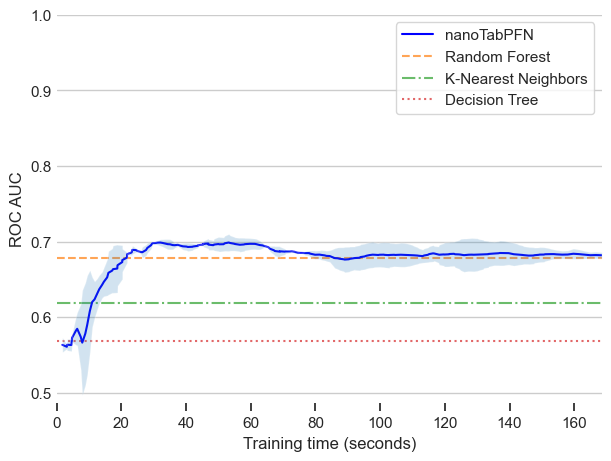

In [12]:
metric = "ROC AUC"
sns.set_style("ticks")
sns.set_context("notebook")
fig, ax = plt.subplots(figsize=(6,4.5), layout="constrained")
plot_runs(ax, histories, metric, baselines)

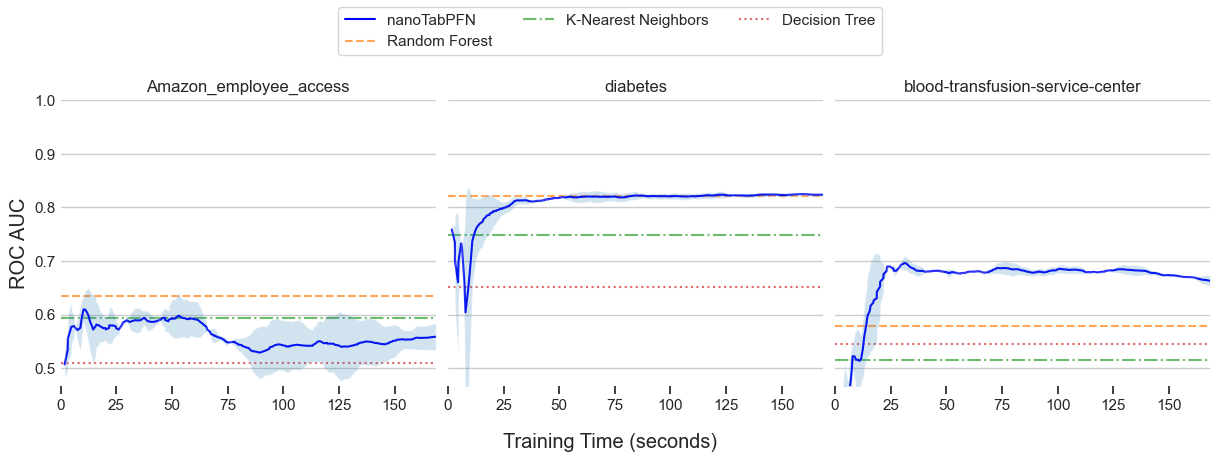

In [13]:
sns.set_context("notebook")
fig, ax = plot_run_grid(histories, baselines)
plt.show()
fig.savefig(f"nanotabpfn_summary.png", dpi=300)


NanoTabPFN with MultiHeadAttention from scratch 

In [5]:
#reload le model a chaque fois qu'il est modifie
import importlib
import model
import attentions  
importlib.reload(model)
importlib.reload(attentions) 
from model import NanoTabPFNModel

In [ ]:
from model import NanoTabPFNModel
from train import PriorDumpDataLoader, train, get_default_device, set_randomness_seed

histories_local = []
device = get_default_device()

for seed in [0, 111]:
    set_randomness_seed(seed)
    prior = PriorDumpDataLoader("300k_150x5_2.h5", num_steps=2500, batch_size=32, device=device)
    model = NanoTabPFNModel(
            embedding_size=96,
            num_attention_heads=4,
            mlp_hidden_size=192,
            num_layers=3,
            num_outputs=3,
            attention_type="Scratch"
        )
    eval_model_partial = functools.partial(eval_model, datasets=DATASETS)
    model, history = train(model, prior, lr=4e-3, steps_per_eval=25, eval_func=eval_model_partial)
    history = [{**record, "training_time": training_time} for (training_time, record) in history]
    history = pd.DataFrame(history)
    histories_local.append(history)

time     1.7s | loss  0.4954 | Amazon_employee_access/ROC AUC  0.4003 | blood-transfusion-service-center/ROC AUC  0.4300 | diabetes/ROC AUC  0.7741 | ROC AUC  0.5348
time     3.1s | loss  0.5322 | Amazon_employee_access/ROC AUC  0.5009 | blood-transfusion-service-center/ROC AUC  0.4014 | diabetes/ROC AUC  0.5687 | ROC AUC  0.4903
time     4.6s | loss  0.5367 | Amazon_employee_access/ROC AUC  0.6223 | blood-transfusion-service-center/ROC AUC  0.4373 | diabetes/ROC AUC  0.4485 | ROC AUC  0.5027
time     6.0s | loss  0.4649 | Amazon_employee_access/ROC AUC  0.6392 | blood-transfusion-service-center/ROC AUC  0.4276 | diabetes/ROC AUC  0.5943 | ROC AUC  0.5537
time     7.5s | loss  0.5290 | Amazon_employee_access/ROC AUC  0.6121 | blood-transfusion-service-center/ROC AUC  0.5338 | diabetes/ROC AUC  0.5246 | ROC AUC  0.5568
time     8.9s | loss  0.4887 | Amazon_employee_access/ROC AUC  0.6121 | blood-transfusion-service-center/ROC AUC  0.4994 | diabetes/ROC AUC  0.6892 | ROC AUC  0.6003
time

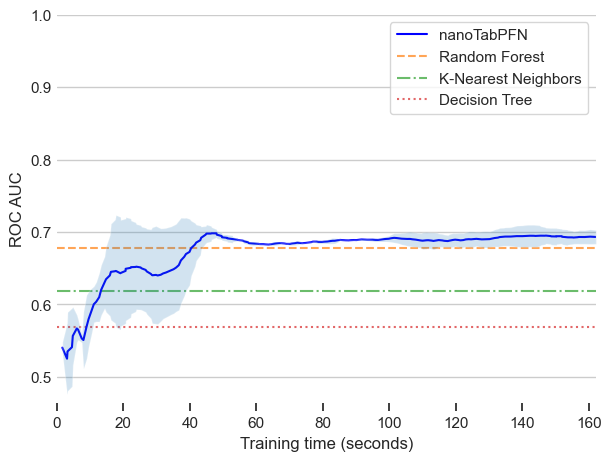

In [15]:
metric = "ROC AUC"
sns.set_style("ticks")
sns.set_context("notebook")
fig, ax = plt.subplots(figsize=(6,4.5), layout="constrained")
plot_runs(ax, histories_local, metric, baselines)

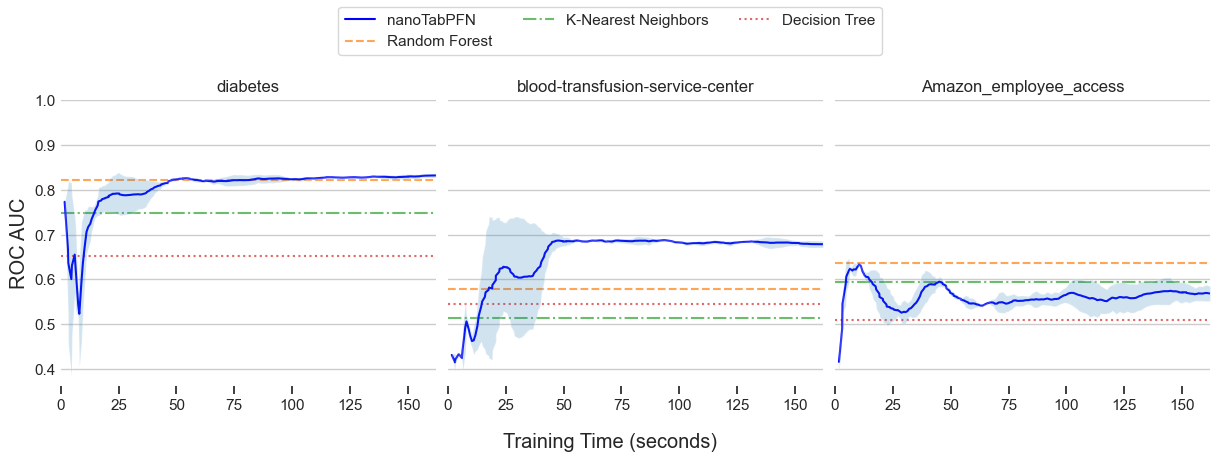

In [16]:
sns.set_context("notebook")
fig, ax = plot_run_grid(histories_local, baselines)
plt.show()
fig.savefig(f"nanotabpfn_MyOriginalAttention_summary.png", dpi=300)

NanoTabPFN with local sliding window attention


In [6]:
#reload le model a chaque fois qu'il est modifie
import importlib
import model
import attentions  
importlib.reload(attentions)
importlib.reload(model)
from model import NanoTabPFNModel

In [ ]:
from model import NanoTabPFNModel
from train import PriorDumpDataLoader, train, get_default_device, set_randomness_seed

histories_sliding = []
device = get_default_device()

#for seed in [0, 111]:
for seed in [0]:
    set_randomness_seed(seed)
    prior = PriorDumpDataLoader("300k_150x5_2.h5", num_steps=2500, batch_size=32, device=device)
    model = NanoTabPFNModel(
            embedding_size=96,
            num_attention_heads=4,
            mlp_hidden_size=192,
            num_layers=3,
            num_outputs=3,
            attention_type="Local"
        )
    eval_model_partial = functools.partial(eval_model, datasets=DATASETS)
    model, history = train(model, prior, lr=4e-3, steps_per_eval=25, eval_func=eval_model_partial)
    history = [{**record, "training_time": training_time} for (training_time, record) in history]
    history = pd.DataFrame(history)
    histories_sliding.append(history)

time     1.8s | loss  0.4866 | Amazon_employee_access/ROC AUC  0.4809 | blood-transfusion-service-center/ROC AUC  0.4273 | diabetes/ROC AUC  0.7718 | ROC AUC  0.5600
time     3.3s | loss  0.5399 | Amazon_employee_access/ROC AUC  0.5625 | blood-transfusion-service-center/ROC AUC  0.5561 | diabetes/ROC AUC  0.2340 | ROC AUC  0.4509
time     4.8s | loss  0.5377 | Amazon_employee_access/ROC AUC  0.5328 | blood-transfusion-service-center/ROC AUC  0.4975 | diabetes/ROC AUC  0.2840 | ROC AUC  0.4381
time     6.3s | loss  0.4670 | Amazon_employee_access/ROC AUC  0.5731 | blood-transfusion-service-center/ROC AUC  0.4310 | diabetes/ROC AUC  0.5176 | ROC AUC  0.5072
time     7.9s | loss  0.5277 | Amazon_employee_access/ROC AUC  0.5767 | blood-transfusion-service-center/ROC AUC  0.5010 | diabetes/ROC AUC  0.3779 | ROC AUC  0.4852
time     9.4s | loss  0.4969 | Amazon_employee_access/ROC AUC  0.5904 | blood-transfusion-service-center/ROC AUC  0.4862 | diabetes/ROC AUC  0.6435 | ROC AUC  0.5734
time

In [19]:
print(type(histories_sliding))
print(len(histories_sliding))
print(histories_sliding[0])

<class 'list'>
2
    Amazon_employee_access/ROC AUC  blood-transfusion-service-center/ROC AUC  \
0                         0.480940                                  0.427289   
1                         0.562500                                  0.556127   
2                         0.532801                                  0.497464   
3                         0.573138                                  0.430990   
4                         0.576684                                  0.501028   
..                             ...                                       ...   
95                        0.584663                                  0.677152   
96                        0.592642                                  0.673862   
97                        0.587323                                  0.674274   
98                        0.583777                                  0.673725   
99                        0.587766                                  0.675644   

    diabetes/ROC AUC  

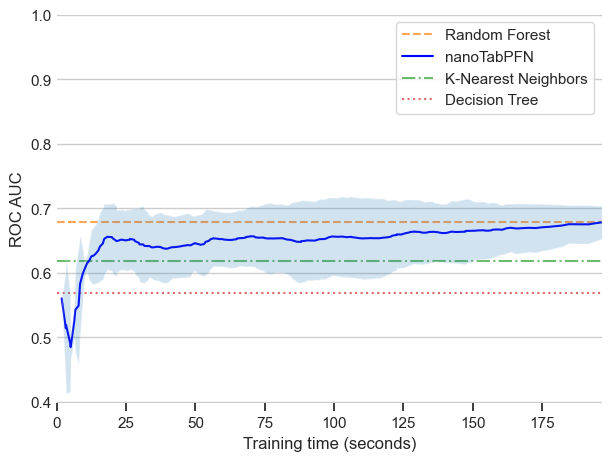

In [8]:
metric = "ROC AUC"
sns.set_style("ticks")
sns.set_context("notebook")
fig, ax = plt.subplots(figsize=(6,4.5), layout="constrained")
plot_runs(ax, histories_sliding, metric, baselines)

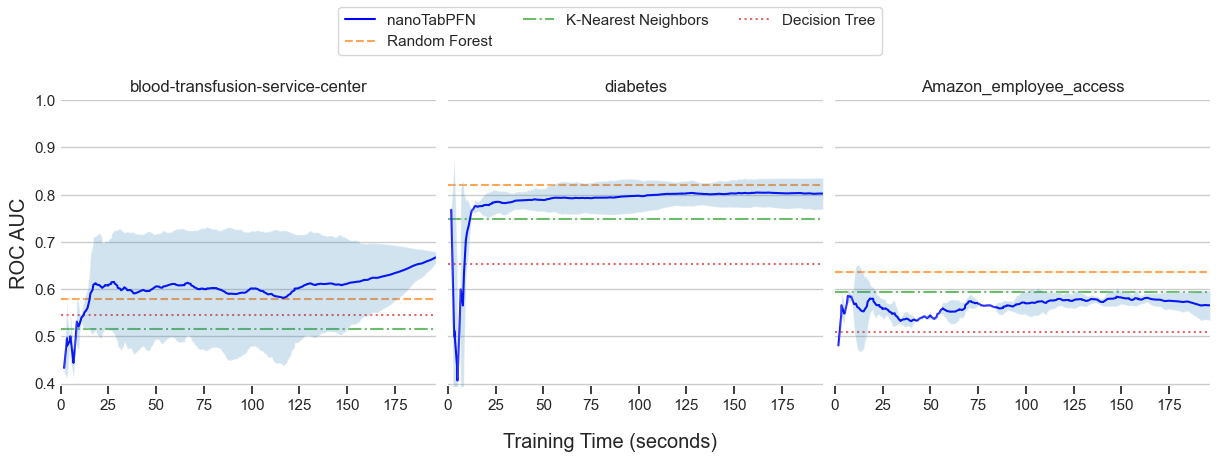

In [9]:
sns.set_context("notebook")
fig, ax = plot_run_grid(histories_sliding, baselines)
plt.show()
fig.savefig(f"nanotabpfn_SlidingWindowAttention_summary.png", dpi=300)

In [7]:
import h5py
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import openml

In [19]:
import importlib
import preprocessing
importlib.reload(preprocessing) #il faut reload l'importer des que tu fais un changement a la classe

<module 'preprocessing' from '/Users/salomegobbi/Desktop/nanoTabPFN/preprocessing.py'>

In [20]:
from preprocessing import create_h5_prior_from_dataset

In [23]:
from model import NanoTabPFNModel
from train import PriorDumpDataLoader, train, get_default_device, set_randomness_seed

histories = []
device = get_default_device()

for seed in [0, 111]:
    set_randomness_seed(seed)
    prior = PriorDumpDataLoader("coucou.h5", num_steps=2500, batch_size=32, device=device)
    model = NanoTabPFNModel(
            embedding_size=96,
            num_attention_heads=4,
            mlp_hidden_size=192,
            num_layers=3,
            num_outputs=3
        )
    eval_model_partial = functools.partial(eval_model, datasets=DATASETS)
    model, history = train(model, prior, lr=4e-3, steps_per_eval=25, eval_func=eval_model_partial)
    history = [{**record, "training_time": training_time} for (training_time, record) in history]
    history = pd.DataFrame(history)
    histories.append(history)


NameError: name 'functools' is not defined

In [2]:
file_path = "300k_150x5_2.h5"  # or your file
with h5py.File(file_path, "r") as f:
    # List top-level keys
    print(f)
    print("Keys:", list(f.keys()))

    X = f['X'][:]
    print("X shape: ", X.shape)
    y = f['y'][:]
    print("y shape: ", y.shape)
    print("y dtype:", y.dtype)

    # Explore a single task
    first_task_key = list(f.keys())[0]
    print("Task key:", first_task_key)
    
    task_data = f[first_task_key]
  
   

<HDF5 file "300k_150x5_2.h5" (mode r)>
Keys: ['X', 'max_num_classes', 'num_datapoints', 'num_features', 'original_batch_size', 'problem_type', 'single_eval_pos', 'y']
X shape:  (300000, 150, 5)
y shape:  (300000, 150)
y dtype: float32
Task key: X


In [21]:
create_h5_prior_from_dataset(40691, "coucou.h5")

/Users/salomegobbi/Desktop/nanoTabPFN/preprocessing.py:12: FutureWarning: ``download_all_files`` is experimental and is likely to break with new releases.
  dataset = openml.datasets.get_dataset(dataset_id, download_all_files=True)
Could not download file from https://openml.org/datasets/0004/40691/dataset_40691.pq: HTTPSConnectionPool(host='www.openml.org', port=443): Max retries exceeded with url: https://www.openml.org/datasets/0004/40691/dataset_40691.pq (Caused by ResponseError('too many redirects'))


Saved tasks here here  to coucou.h5


In [22]:
file_path = "coucou.h5"  # or your file
with h5py.File(file_path, "r") as f:
    # List top-level keys
    print(f)
    print("Keys:", list(f.keys()))

    X = f['X'][:]
    print(X.shape)
    y = f['y'][:]
    print(y.shape)
    print(y.dtype)

    # Explore a single task
    first_task_key = list(f.keys())[0]
    print("Task key:", first_task_key)
    
    task_data = f[first_task_key]

<HDF5 file "coucou.h5" (mode r)>
Keys: ['X', 'max_num_classes', 'num_datapoints', 'num_features', 'single_eval_pos', 'y']
(5000, 40, 11)
(5000, 40)
float32
Task key: X


In [ ]:
print("hello")